<a href="https://colab.research.google.com/github/indiee27/IPMI-Portfolio/blob/main/IPMI20_21_Semantic_Segmentation_Brain_Tumours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IPMI20-21 Laboratory Session**
---
#**Semantic Segmentation Brain Tumours**

This tutorial is solving a real-world problem in segmenting brain tumours in slices of T1-weighted MR images using UNets for supervised learning. The dataset includes patients with gliomas, complete with manual 'ground-truth' masks.<br>
###Exercise
**You should use these data to produce brief report that includes tables and/or figures that summarises the results.**<br> How do some of the parameters affect the performance of the network? Include 1-2 example images of subjects that worked very well, and others that didn't work at all.
<br>Please share your report with one of the teaching team for some feedback prior to leaving the session.

---
The tutorial requires graphical processing units, **so before you start, make sure that you are connected to a GPU runtime.**

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Get brain tumor images
Download using the wget system command. This can take 2-3 minutes.

In [ ]:
!wget -O glioma_images.npy --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/rmapjrm_ucl_ac_uk/ETiEHiYhTFNFmvpGu1pyXT4BIHBLVGfwwdjcvO0EuCWLUg?e=bjAnBq&download=1"
!wget -O glioma_masks.npy --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/rmapjrm_ucl_ac_uk/Ea8pdBNHEe1AloRg5YuCDiEBMcMR0_svXjbcHJOE1dwG2w?e=KD9YHq&download=1"

--2021-03-18 09:37:38--  https://liveuclac-my.sharepoint.com/:u:/g/personal/rmapjrm_ucl_ac_uk/ETiEHiYhTFNFmvpGu1pyXT4BIHBLVGfwwdjcvO0EuCWLUg?e=bjAnBq&download=1
Resolving liveuclac-my.sharepoint.com (liveuclac-my.sharepoint.com)... 13.107.136.9
Connecting to liveuclac-my.sharepoint.com (liveuclac-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/rmapjrm_ucl_ac_uk/Documents/IPMI%20course/2020-21%20material/Coursework/brain_tumour_files/glioma_images.npy?originalPath=aHR0cHM6Ly9saXZldWNsYWMtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvcm1hcGpybV91Y2xfYWNfdWsvRVRpRUhpWWhURk5GbXZwR3UxcHlYVDRCSUhCTFZHZnd3ZGpjdk8wRXVDV0xVZz9ydGltZT0yN1I3ZVBIcDJFZw [following]
--2021-03-18 09:37:39--  https://liveuclac-my.sharepoint.com/personal/rmapjrm_ucl_ac_uk/Documents/IPMI%20course/2020-21%20material/Coursework/brain_tumour_files/glioma_images.npy?originalPath=aHR0cHM6Ly9saXZldWNsYWMtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvcm1hcGpy

Check the files have loaded and are of the right size (~700MB, ~350MB)

In [ ]:
!du -sh glioma*

714M	glioma_images.npy
357M	glioma_masks.npy


Load image and mask data as numpy arrays. Check the data types are as expected.



In [ ]:
images = np.load('glioma_images.npy')
masks = np.load('glioma_masks.npy')
print(images.shape)
print(images.dtype)
print(masks.shape)
print(masks.dtype)

(1426, 512, 512)
int16
(1426, 512, 512)
bool


#Visualisation
##Plot single subject
Load an image and matching tumour segmentation mask

Subject #1281


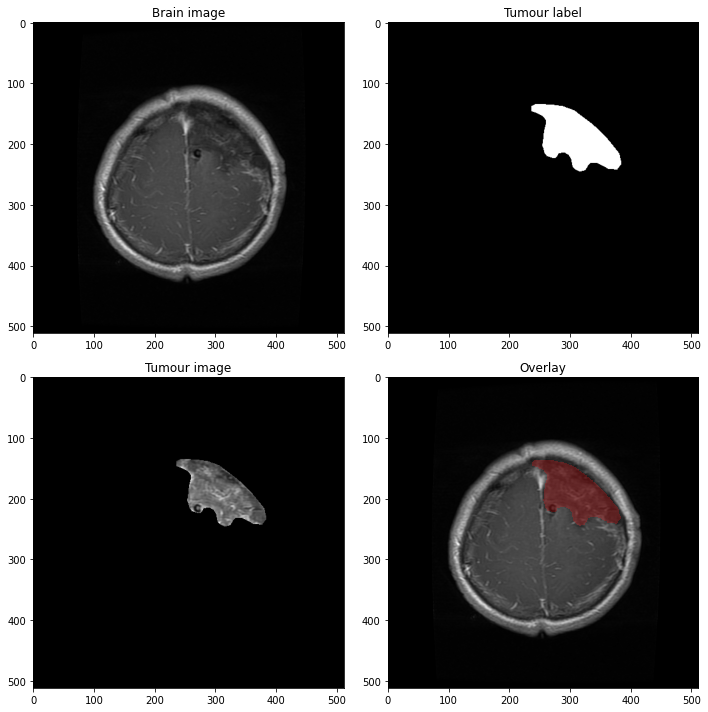

In [ ]:
idx = random.randint(0,images.shape[0])
print("Subject #" + str(idx))
image = images[idx,:,:]
mask = masks[idx,:,:]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].imshow(image, cmap = 'gray')
axes[0,1].imshow(mask, cmap = 'gray')
axes[1,0].imshow(image * mask, cmap = 'gray')
axes[1,1].imshow(image, cmap = 'gray')
axes[1,1].imshow(np.ma.masked_where(mask == False, mask), alpha=0.3, cmap = 'Set1') # set black pixel as transparent for the mask
axes[0,0].title.set_text('Brain image')
axes[0,1].title.set_text('Tumour label')
axes[1,0].title.set_text('Tumour image')
axes[1,1].title.set_text('Overlay')
plt.tight_layout()

##Plot multiple subjects

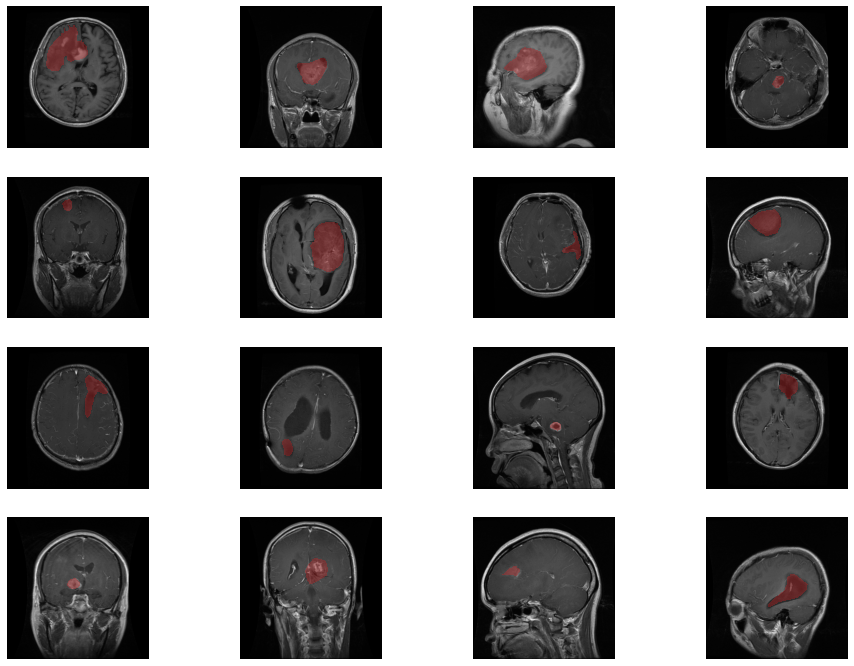

In [ ]:
plt.figure(figsize=(16, 12))
for i, idx in enumerate(np.random.randint(images.shape[0], size=16), start=1):
    plt.subplot(4, 4, i)
    plt.imshow(images[idx], cmap='gray')
    
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')
    plt.axis('off')

#UNet for image segmentation

##Create training and test data
Need to randomly select a proportion of data for training and testing

In [ ]:
def train_test_split(image_data, mask_data, train_proportion):
    np.random.seed(38)
    train_proportion = train_proportion
    train_index = np.random.choice(image_data.shape[0], size = int(image_data.shape[0] * train_proportion), replace = False)
    print(str("Training set = ") + str("{:.0%}".format(train_proportion)) + str(", n = ") + str(len(train_index)))
    
    x_train = image_data[train_index, :, :]
    x_train = np.expand_dims(x_train, axis=3)

    y_train = mask_data[train_index, :, :]
    y_train = np.expand_dims(y_train, axis=3)

    x_test = np.delete(image_data, train_index, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = np.delete(mask_data, train_index, axis=0)
    y_test = np.expand_dims(y_test, axis=3)
    return x_train, y_train, x_test, y_test

Generate your training and test data. The inputs here are the images and corresponding mask file.<br>
You can set the proportion of data to be used for training; the remainder will be used for testing.

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(image_data = images, mask_data = masks, train_proportion = 0.8)

Training set = 80%, n = 1140


Check data shapes and formats

In [ ]:
print(x_train.shape)
print(y_train.dtype)
print(x_test.shape)
print(y_test.dtype)

(1140, 512, 512, 1)
bool
(286, 512, 512, 1)
bool


###Check that the data are properly specified
This will run on a random subject each time

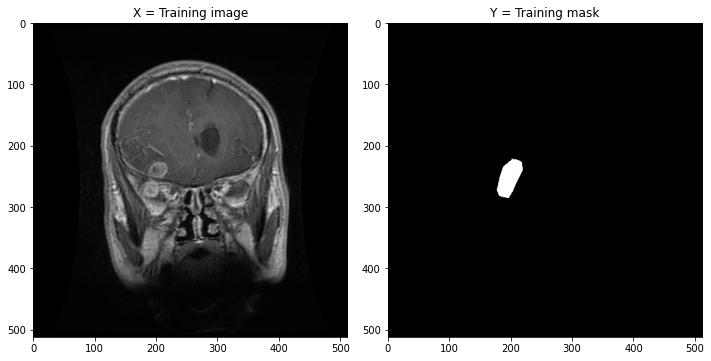

In [ ]:
idx = random.randint(0,x_train.shape[0])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(np.squeeze(x_train[idx]), cmap='gray')
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax1.title.set_text('X = Training image')
ax2.title.set_text('Y = Training mask')
plt.tight_layout()

Plot histogram/bar-plot of x_train (images) and y_train (masks)

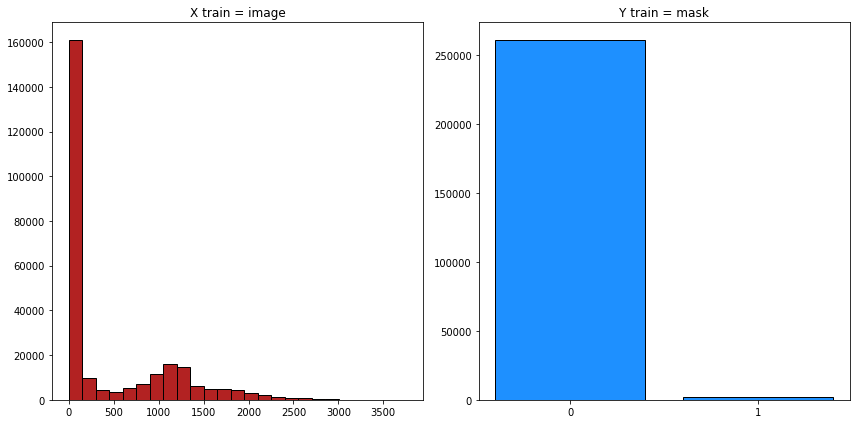

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(np.concatenate(x_train[idx]), bins=25, facecolor='firebrick', edgecolor='black')
ax2.bar(x=['0','1'], height=np.unique(y_train[idx], return_counts=True)[1], facecolor='dodgerblue', edgecolor='black')
ax1.title.set_text('X train = image')
ax2.title.set_text('Y train = mask')
plt.tight_layout()

##Custom performance metrics


Intersection over union (IoU), also known as the Jaccard Index. Area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.

In [ ]:
from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_loss(y_true, y_pred):
    return 1-iou_coef(y_true, y_pred)

Alternative implementation of the Jaccard Index

In [ ]:
from tensorflow.keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

Dice overlap coefficient. Double the sum of the intersection over the total size of the area of both regions.

In [ ]:
from tensorflow.keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Focal loss. Requires Tensorflow Addons<br>
https://neptune.ai/blog/keras-loss-functions


In [ ]:
# !pip install -U tensorflow-addons
# import tensorflow_addons as tfa

##Define UNet architecture
#### The following elements can be included the architecture:
- 2D convolution with padded feature maps (for convenience in working out the sizes at different resolution levels)
- nonlinear activation
- pooling layer
- normalisation layer
- dropout

### Function to define convolutional blocks
Adds two convolutional layers with the parameters passed to it.


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, activ_func='relu', batchnorm = True, pad='same'):
    # first layer
    block = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = pad)(input_tensor)
    if batchnorm:
        block = tf.keras.layers.BatchNormalization()(block)
    block = tf.keras.layers.Activation(activ_func)(block)
    
    # second layer
    block = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = pad)(input_tensor)
    if batchnorm:
        block = tf.keras.layers.BatchNormalization()(block)
    block = tf.keras.layers.Activation(activ_func)(block)
    
    return block

### Function to define UNet layers
Changing variables such as the number of filters, dropout rate and pool size for the max-pooling layer will influence prediction performance.

In [ ]:
def unet(input_img, n_filters=16, dropout=0.1, pool_size=(2,2), pad='same'):
  s = tf.keras.layers.Lambda(lambda x: x / 255)(input_img)
  # Contracting path
  c1 = conv2d_block(input_img, n_filters=n_filters)
  c1 = tf.keras.layers.Dropout(dropout)(c1)
  p1 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c1)
 
  c2 = conv2d_block(p1, n_filters=n_filters * 2)
  c2 = tf.keras.layers.Dropout(dropout)(c2)
  p2 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c2)
 
  c3 = conv2d_block(p2, n_filters=n_filters * 4)
  c3 = tf.keras.layers.Dropout(dropout)(c3)
  p3 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c3)
  
  c4 = conv2d_block(p3, n_filters=n_filters * 8)
  c4 = tf.keras.layers.Dropout(dropout)(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c4)
  
  c5 = conv2d_block(p4, n_filters=n_filters * 16)
  c5 = tf.keras.layers.Dropout(dropout)(c5)
    
  # Expanding path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=pad)(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = conv2d_block(c6, n_filters=n_filters * 8)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=pad)(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = conv2d_block(c7, n_filters=n_filters * 4)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=pad)(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = conv2d_block(c8, n_filters=n_filters * 2)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=pad)(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = conv2d_block(c9, n_filters=n_filters)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = tf.keras.models.Model(inputs=[input_img], outputs=[outputs])
  return model

##Generate model
Can set input dimensions, channels and other parameters, as well as chose the optimiser. Adam is commonly used for Unets.
The loss function for image segmentation can be binary cross-entropy, treating segmentation as a voxel classification problem. Alongside the loss function, other metrics can be reported to get a better idea of performance.

In [ ]:
IMG_WIDTH = x_train.shape[1]
IMG_HEIGHT = x_train.shape[2]
IMG_CHANNELS = 1
input_img = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = unet(input_img, dropout=0.1, pool_size=(2,2), pad='same')
adam = tf.keras.optimizers.Adam(lr=0.001)
loss_func='binary_crossentropy'
## compile model
model.compile(optimizer=adam,
              loss=loss_func,            
              metrics=[iou_coef, dice_coef, 'accuracy'])

Print out a summary of the model's architecture. Note how many parameters are destined to be optimised during training.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

## Visualise network
Uses Keras utilities. This IS a U-Net, just on its side. The dpi argument controls the size here.

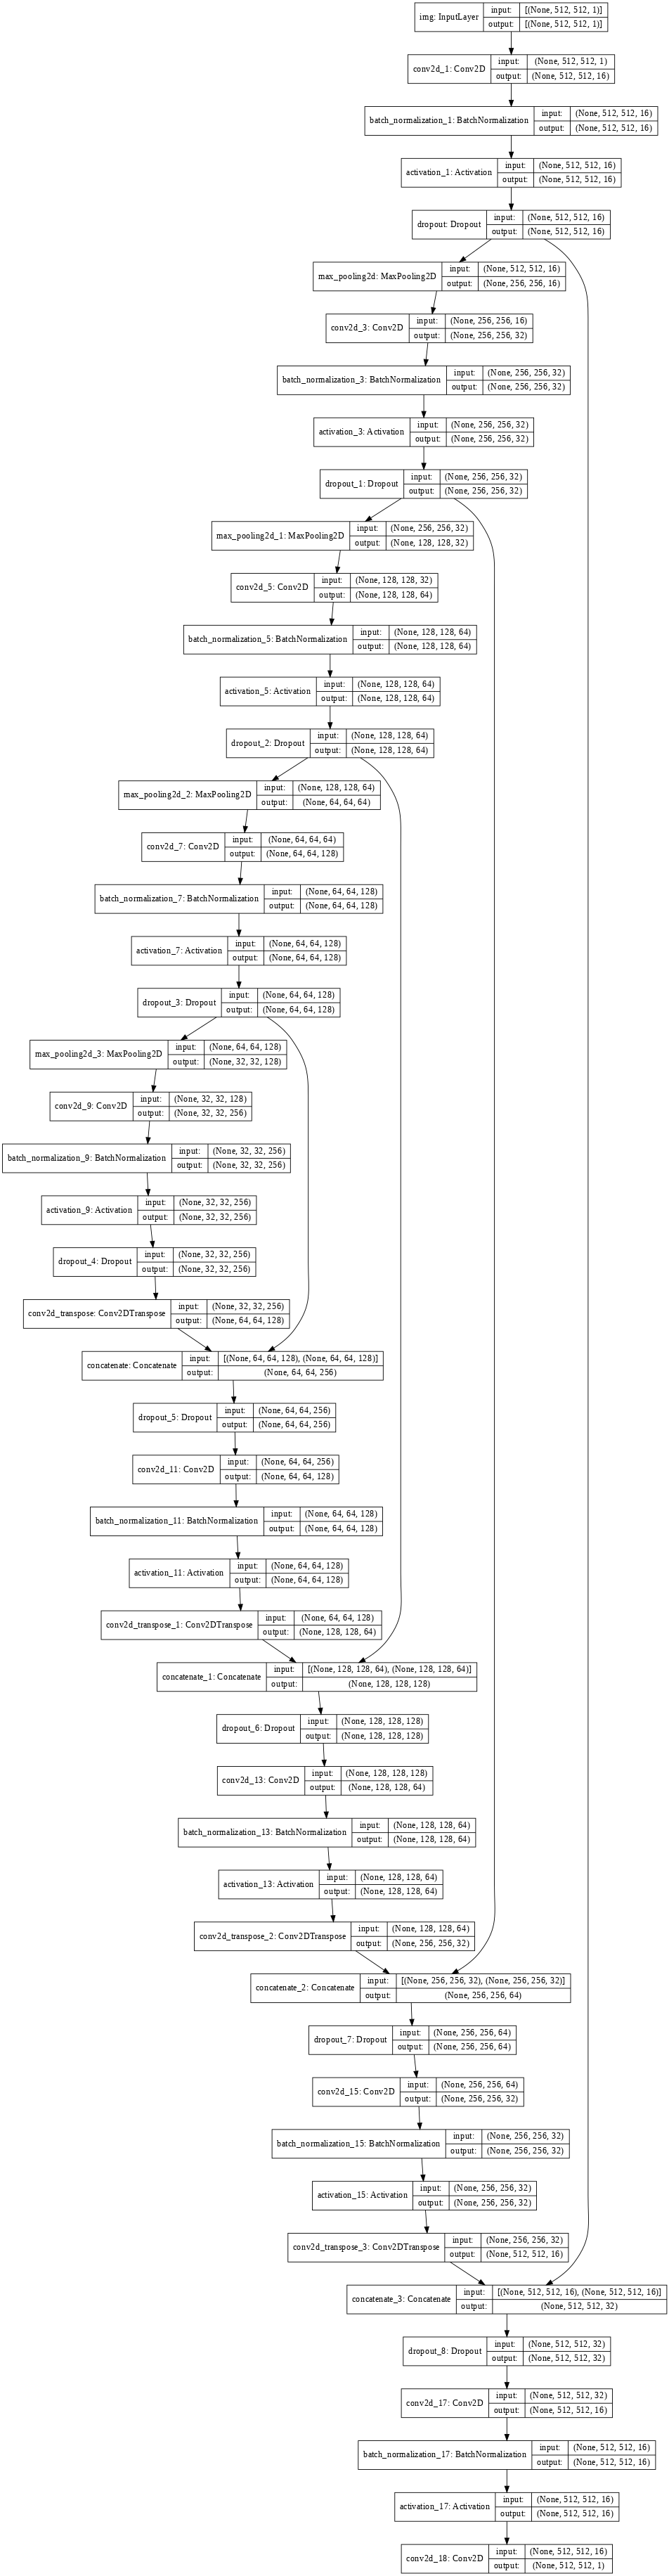

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, dpi=64)

How to save model architecture to JSON

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Read in and print JSON file. This is the full details of your architecture.

In [ ]:
json.load(open('model.json', 'r'))

{'backend': 'tensorflow',
 'class_name': 'Functional',
 'config': {'input_layers': [['img', 0, 0]],
  'layers': [{'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 512, 512, 1],
     'dtype': 'float32',
     'name': 'img',
     'ragged': False,
     'sparse': False},
    'inbound_nodes': [],
    'name': 'img'},
   {'class_name': 'Conv2D',
    'config': {'activation': 'linear',
     'activity_regularizer': None,
     'bias_constraint': None,
     'bias_initializer': {'class_name': 'Zeros', 'config': {}},
     'bias_regularizer': None,
     'data_format': 'channels_last',
     'dilation_rate': [1, 1],
     'dtype': 'float32',
     'filters': 16,
     'groups': 1,
     'kernel_constraint': None,
     'kernel_initializer': {'class_name': 'HeNormal',
      'config': {'seed': None}},
     'kernel_regularizer': None,
     'kernel_size': [3, 3],
     'name': 'conv2d_1',
     'padding': 'same',
     'strides': [1, 1],
     'trainable': True,
     'use_bias': True},
    'inb

#Train model

Create checkpoints for logging model performance during training and define callbacks to enable early stopping or adaptively change the learning rate on a plateau in performance. Changing the patience argument will influence when early stopping happens.<br>
If you get out of memory errors (OOM), you can try reducing the batch size. Training will take longer, but should give similar results. Altering the early stopping criteria (e.g., min delta), the maximum number of epochs or even the optimiser's learning rate will reduce training time.
We save the best model (not necessarily the last one) for final testing.

In [ ]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
  tf.keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

**Fit model**<br>
Consider changing the training/validation split, the mini-batch size or the number of epochs and assess the impact this has on results.

In [ ]:
results = model.fit(x=x_train, y=y_train,
                    validation_split=0.2,
                    batch_size=16,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - 48s 269ms/step - loss: 0.6838 - iou_coef: 0.0241 - dice_coef: 0.0476 - accuracy: 0.6130 - val_loss: 0.7784 - val_iou_coef: 0.0240 - val_dice_coef: 0.0477 - val_accuracy: 0.8529

Epoch 00001: val_loss improved from inf to 0.77838, saving model to best_model.h5
Epoch 2/50
57/57 [==============================] - 14s 252ms/step - loss: 0.3089 - iou_coef: 0.0265 - dice_coef: 0.0526 - accuracy: 0.9764 - val_loss: 0.2489 - val_iou_coef: 0.0288 - val_dice_coef: 0.0575 - val_accuracy: 0.9770

Epoch 00002: val_loss improved from 0.77838 to 0.24893, saving model to best_model.h5
Epoch 3/50
57/57 [==============================] - 14s 252ms/step - loss: 0.2359 - iou_coef: 0.0265 - dice_coef: 0.0532 - accuracy: 0.9779 - val_loss: 0.1949 - val_iou_coef: 0.0282 - val_dice_coef: 0.0570 - val_accuracy: 0.9779

Epoch 00003: val_loss improved from 0.24893 to 0.19486, saving model to best_model.h5
Epoch 4/50
57/57 [==============================] - 14s 

### Visualise model training

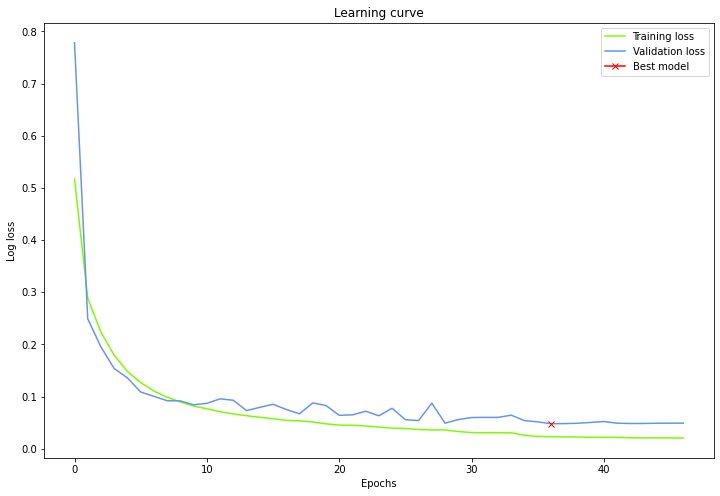

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="Training loss", color='lawngreen')
plt.plot(results.history["val_loss"], label="Validation loss", color='cornflowerblue')
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]),
         marker="x", color="red", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.legend();

After training you can look at various various parametetrs of the model, such as the learning rate and weight decay.

In [ ]:
from tensorflow.keras import backend as K
print("learning rate = "  + str(K.eval(model.optimizer.lr)))

learning rate = 1e-05


#Evaluate performance

Load checkpoint data and get performance on test data using training weights

In [ ]:
model.load_weights('best_model.h5')
model.evaluate(x_test,  y_test, verbose=2)


9/9 - 3s - loss: 0.0442 - iou_coef: 0.3090 - dice_coef: 0.5063 - accuracy: 0.9860


[0.04420923814177513,
 0.30904287099838257,
 0.5062862634658813,
 0.9859644770622253]

##Apply to test data
This step generates the predicted mask images in 2D

In [ ]:
predict = model.predict(x_test, verbose=1)
predict = (predict > 0.5).astype(np.int8)

9/9 [==============================] - 1s 136ms/step


##Calculate Dice overlap coefficient per subject
As above Dice is 2 * the area of overlap divided by the total number of pixels in both images. This function can be used to test the overlap with a single predicted mask.

In [ ]:
def get_dice(idx):
  seg = np.squeeze(predict[idx])
  gt = np.squeeze(y_test[idx])
  dice = np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))
  return dice

Calculate the Dice score for all subjects and summarise.

In [ ]:
dices = []
for i in range(x_test.shape[0]):
  dices.append(get_dice(i))

print('mean = ' + '{:.3f}'.format(np.mean(dices)))
print('median = ' + '{:.3f}'.format(np.median(dices)))
print('SD = ' + '{:.3f}'.format(np.std(dices)))

mean = 0.504
median = 0.592
SD = 0.324


Histogram to show distribution of Dice scores

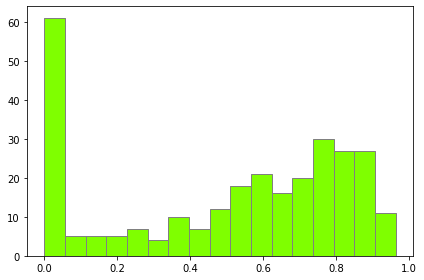

In [ ]:
plt.hist(dices, bins='sqrt', facecolor='chartreuse', edgecolor='grey')
plt.tight_layout()

Find the subject with the highest Dice overlap

In [ ]:
maxDice = np.where(dices == np.amax(dices))
print('ID = ' + str(maxDice[0]))
print('{:.2f}'.format(get_dice(maxDice[0])))

ID = [134]
0.96


Visualise the predictions for the subject with highest overlap

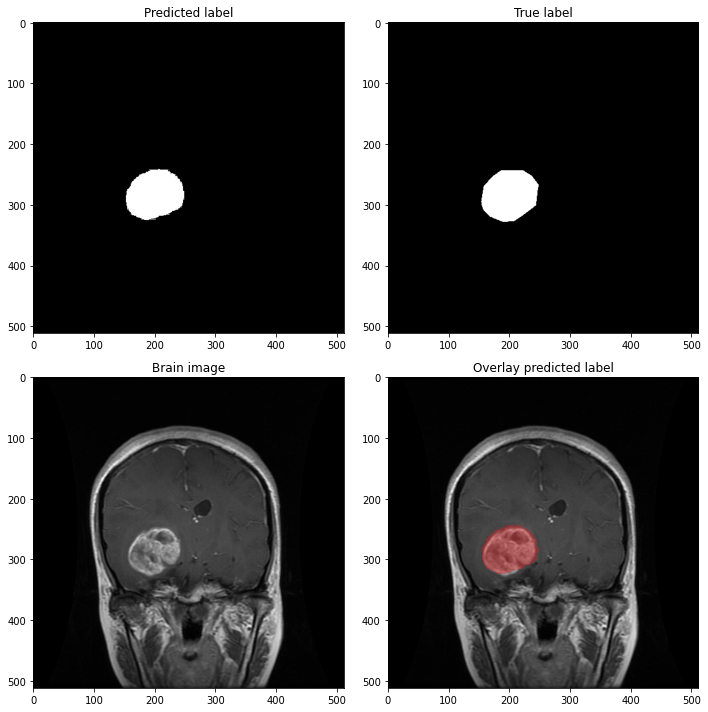

In [ ]:
idx = maxDice[0]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].imshow(np.squeeze(predict[idx]), cmap='gray')
axes[0,1].imshow(np.squeeze(y_test[idx]), cmap='gray')
axes[1,0].imshow(np.squeeze(x_test[idx]), cmap='gray')
axes[1,1].imshow(np.squeeze(x_test[idx]), cmap = 'gray')
axes[1,1].imshow(np.ma.masked_where(np.squeeze(predict[idx]) == False, np.squeeze(predict[idx])), alpha=0.4, cmap = 'Set1')
axes[0,0].title.set_text('Predicted label')
axes[0,1].title.set_text('True label')
axes[1,0].title.set_text('Brain image')
axes[1,1].title.set_text('Overlay predicted label')
plt.tight_layout()

Bar plot to illustrate the imbalance in 0s and 1s in the image.

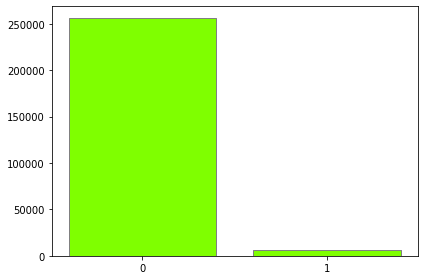

In [ ]:
idx = maxDice[0]
plt.figure(figsize=(6,4))
plt.bar(x=['0','1'], height=np.unique(predict[idx], return_counts=True)[1], facecolor='chartreuse', edgecolor='grey')
plt.tight_layout()

## Correlations between mask volumes

Function to get the size (i.e., number of pixels) for the true mask and predicted mask

In [ ]:
def get_mask_sizes(idx):
    true_mask_size = np.count_nonzero(y_test[idx])
    predicted_mask_size = np.count_nonzero(predict[idx])
    return true_mask_size, predicted_mask_size

Run on example subject

In [ ]:
get_mask_sizes(idx = maxDice[0])

(6257, 6173)

Loop through all the test data

In [ ]:
true_masks = [get_mask_sizes(x)[0] for x in range(y_test.shape[0])]
predicted_masks = [get_mask_sizes(x)[1] for x in range(y_test.shape[0])]

Correlation between the true mask sizes and predicted mask sizes

In [ ]:
print('{:.3f}'.format(np.corrcoef(true_masks, predicted_masks)[0,1]))

0.603


Scatterplot of the true mask sizes and predicted mask sizes

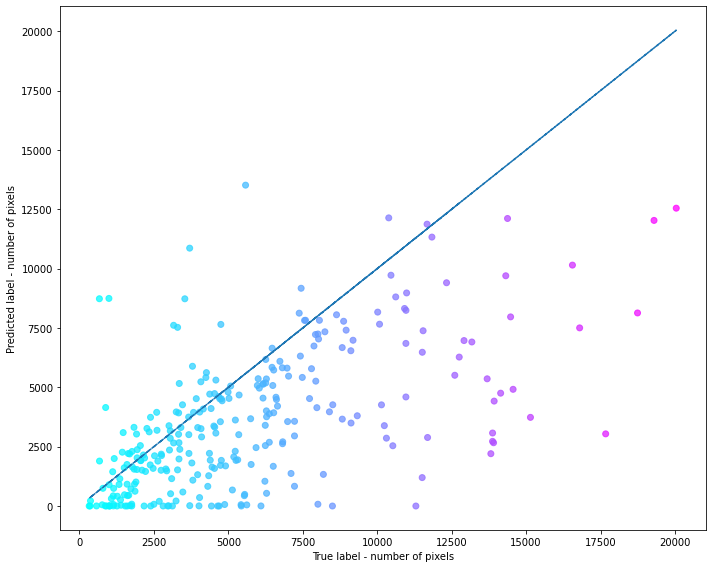

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(true_masks,true_masks, linestyle='dashed')
plt.scatter(true_masks, predicted_masks, c=true_masks, alpha = 0.75, cmap = 'cool')
plt.xlabel("True label - number of pixels")
plt.ylabel("Predicted label - number of pixels")
plt.tight_layout()

#Data augmentation
Create synthetic data based on the real data to augment the training process.<br>
This example data augmentation uses rotations. You can change the subject 'idx' to look at different brains.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=45)                             
# prepare iterator
idx = 3
samples = np.expand_dims(np.expand_dims(images[idx,:,:],-1),0)
it = datagen.flow(samples, batch_size=1)

### Plot augmentations
Generates new images on the fly

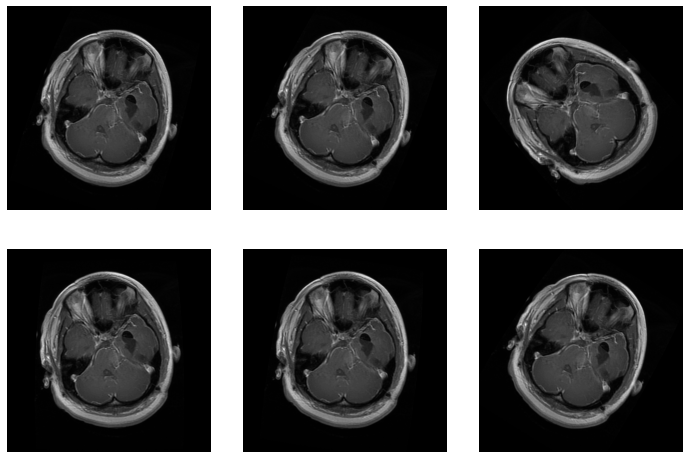

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(6):
	plt.subplot(330 + 1 + i,)
	batch = it.next()
	image = batch[0]
	plt.imshow(np.squeeze(image,-1), cmap='gray')

plt.tight_layout()

for ax in fig.axes:
    ax.axis("off")

## Try more augmentations

In [ ]:
datagen = ImageDataGenerator(width_shift_range=[-20,20],
                             height_shift_range=[-10,10],
                             horizontal_flip=True,
                             rotation_range=90,
                             brightness_range=[0.1,2],
                             zoom_range=0.2)
it = datagen.flow(samples, batch_size=1)

Now plot them

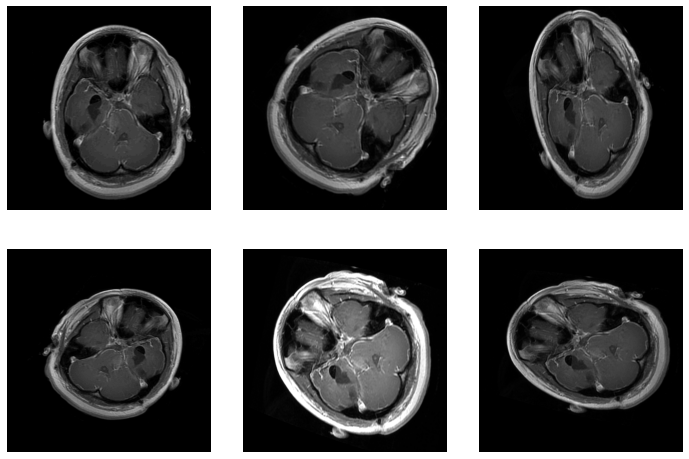

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(6):
	plt.subplot(330 + 1 + i,)
	batch = it.next()
	image = batch[0]
	plt.imshow(np.squeeze(image,-1), cmap='gray')

plt.tight_layout()

for ax in fig.axes:
    ax.axis("off")

## Train a model with augmentation.
Need to apply identical augmentations to image-mask pairs (or the masks won't match the images!). Also need to manually split the training and validation data.

In [ ]:
# we create two instances with the same arguments 
data_gen_args = dict(rotation_range=90) 
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# split data into training and validation
x_train_aug, y_train_aug, x_val_aug, y_val_aug = train_test_split(image_data = x_train, mask_data = y_train, train_proportion = 0.8)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
# image_datagen.fit(np.expand_dims(images,3), augment=True, seed=seed)
# mask_datagen.fit(np.expand_dims(masks,3), augment=True, seed=seed)

image_generator = image_datagen.flow(np.squeeze(x_train_aug, axis=3), seed=seed)
mask_generator = mask_datagen.flow(np.squeeze(y_train_aug, axis=3), seed=seed)

validation_image_generator = image_datagen.flow(np.squeeze(x_val_aug, axis=3), seed=seed)
validation_mask_generator = mask_datagen.flow(np.squeeze(y_val_aug, axis=3), seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)        

Training set = 80%, n = 912


Fit model with augmentation on the fly

In [ ]:
aug_callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
  tf.keras.callbacks.ModelCheckpoint('best_aug_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
aug_results = model.fit(x=train_generator,
                    batch_size=16,
                    epochs=50,
                    callbacks=aug_callbacks,
                    validation_data=validation_generator,
                    steps_per_epoch=50,
                    validation_steps=10,
                    )

Epoch 1/50
50/50 [==============================] - 66s 1s/step - loss: 0.0500 - iou_coef: 0.3199 - dice_coef: 0.5089 - accuracy: 0.9825 - val_loss: 0.0524 - val_iou_coef: 0.2659 - val_dice_coef: 0.4408 - val_accuracy: 0.9829

Epoch 00001: val_loss improved from inf to 0.05239, saving model to best_aug_model.h5
Epoch 2/50
50/50 [==============================] - 63s 1s/step - loss: 0.0482 - iou_coef: 0.2997 - dice_coef: 0.4926 - accuracy: 0.9828 - val_loss: 0.0521 - val_iou_coef: 0.2568 - val_dice_coef: 0.4376 - val_accuracy: 0.9833

Epoch 00002: val_loss improved from 0.05239 to 0.05211, saving model to best_aug_model.h5
Epoch 3/50
50/50 [==============================] - 62s 1s/step - loss: 0.0468 - iou_coef: 0.2958 - dice_coef: 0.4862 - accuracy: 0.9833 - val_loss: 0.0522 - val_iou_coef: 0.2555 - val_dice_coef: 0.4199 - val_accuracy: 0.9829

Epoch 00003: val_loss did not improve from 0.05211
Epoch 4/50
50/50 [==============================] - 63s 1s/step - loss: 0.0476 - iou_coef: 0

Visulise results

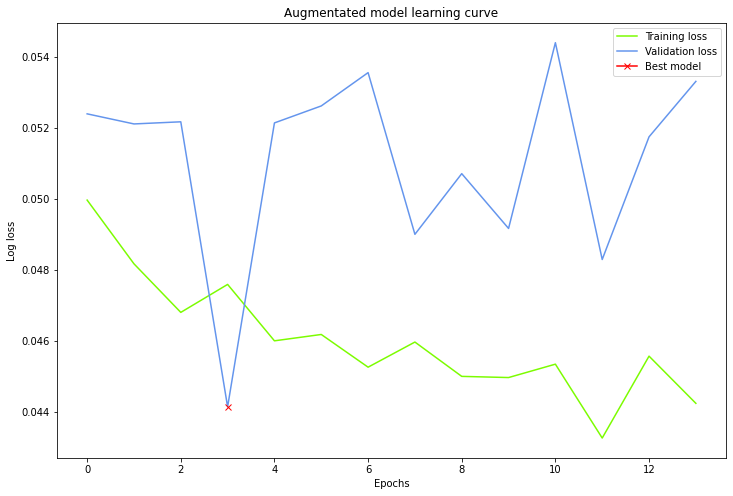

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Augmentated model learning curve")
plt.plot(aug_results.history["loss"], label="Training loss", color='lawngreen')
plt.plot(aug_results.history["val_loss"], label="Validation loss", color='cornflowerblue')
plt.plot(np.argmin(aug_results.history["val_loss"]), np.min(aug_results.history["val_loss"]),
         marker="x", color="red", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.legend();

In [ ]:
model.load_weights('best_aug_model.h5')
model.evaluate(x_test,  y_test, verbose=2)


9/9 - 1s - loss: 0.0412 - iou_coef: 0.2983 - dice_coef: 0.4933 - accuracy: 0.9857


[0.04123295098543167,
 0.2982613742351532,
 0.49325916171073914,
 0.9857362508773804]